In [36]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
# mpl.use("TkCairo")

In [37]:
    
## Get physical constants from Scipy
import scipy.constants as con
## Some useful numerical constants
hbar = con.physical_constants['Planck constant over 2 pi in eV s'][0]
c = con.physical_constants['speed of light in vacuum'][0]*1e2 #cm/m
# k = con.physical_constants['Boltzmann constant in eV/K'][0]

import scipy.integrate as integ

import scipy.io as sio

import scipy.optimize as opt

import scipy.special as spl

## For loading dielectric data fits
import pickle as pkl


In [38]:
misloc_pack_path = os.path.join(
    os.path.sep,
    'Users',
    'chair',
    'Documents',
    'Academia',
    'SuperRes',
    'Biteen_colab',
    'Mispolarization',
    'python',
#     'gitted',
    )

sys.path.append(misloc_pack_path)

import misloc_mispol_package as mmp
import misloc_mispol_package.calc.coupled_dipoles as cp
import misloc_mispol_package.optics.anal_foc_diff_fields as aff

In [39]:
sys.path.append('../modules')
import twosphere_temperature as tst
import pti_model as pti

In [40]:
## Matplotlib settings
## inspired by http://nipunbatra.github.io/2014/08/latexify/
params = {
    'text.latex.preamble': ['\\usepackage{gensymb}'],
    'image.origin': 'lower',
    'image.interpolation': 'nearest',
    'image.cmap': 'magma',
    'axes.grid': False,
    'figure.dpi': 150,  # to adjust notebook inline plot size
    'savefig.dpi': 150,  # to adjust notebook inline plot size
    'axes.labelsize': 12, # fontsize for x and y labels (was 10)
    'axes.titlesize': 14,
    'font.size': 8, # was 10
    'legend.fontsize': 8, # was 10
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'text.usetex': True,
    'figure.figsize': [3.5, 2.625], # 4 x 3
#     'figure.figsize': [4*1.125, 3*1.125], # 4x3, full slide in keynote
    'font.family': 'serif',
    'figure.max_open_warning':100,
    'axes.formatter.limits' : [-3, 3]
}
mpl.rcParams.update(params)   

Path to temperature dependent dielectric data

In [41]:
path_to_diel_data = os.path.join(
    os.path.sep,
    'Users',
    'chair',
    'Documents',
    'Academia',
    'DMREF',
    'dielectrics'
    )

In [42]:
os.path.exists(path_to_diel_data)

True

In [43]:
## Get fit eps parameters dictionary
with open('temp_dep_eps_fits.pkl', 'rb') as handle:
    temp_dep_eps_fits = pkl.load(handle)
## Get fit dndt dictionary
with open('fit_dndt.pkl', 'rb') as handle:
    fit_dndT = pkl.load(handle)

In [44]:
## Get the dndt array (as 2d function of temperature and frequency)
hws = fit_dndT['hws']
dndt_array = fit_dndT['dndt_array']
dnr_dt_array = dndt_array.real
## -------------------

## Calculate finite difference
dni_dt_array = dndt_array.imag
## -------------------

In [45]:
a1 = 10
# eps_back = 1.473**2
eps_back = 1.473**2

In [135]:
def write_title(w0, r_th, phi, a, hw=None):
    phi_str = r'$\phi = $'+f' {phi:.2f}, '
    if hw is not None:
        hw_str = r' at $\hbar\omega = $'+f' {hw:.2f}, '
        phi_str = phi_str[:-2] + hw_str
        
    plt.suptitle(
        r'$w_0 =$'+f' {round(w0):d} [nm], '
        +
        r'$r_\mathrm{th} =$'+f' {round(r_th):d} [nm], '
        +
        phi_str
        +
        r'$a = $'+f' {a:d} [nm]',
        fontsize=6
        )

def get_self_interf_terms_vs_energy(T_expansion, r_th, w0, phi, a, ax=None):
    """ Lengths are input in nm
        """

    ## Get dielectric function and dn/dT
    fit_drude = cp.drude_lorentz_model(
            hws/hbar, 
            *temp_dep_eps_fits[f'{T_expansion:d}K']['x']
            )
    fit_dndT = dndt_array[:, T_expansion]

    (
        alpha0_term, 
        alphapi2_term, 
        alphaphi_term, 
        alphapi2phi_term
        ) = pti.ptsignal_scattering_self_interf_term(
            eps_c=fit_drude,
            eps_b=eps_back,
            a=a*1e-7,
            b=w0*1e-7,
            r_th=r_th*1e-7,
            dndT_c= fit_dndT,
            phi=phi,
#             P_abs=None,
#             dndT_b=dndT_glycerol,
#             kappa=kappa_glycerol,
#             E_probe=1,
#             G_=1,
            return_components=True,
            )
    return alpha0_term, alphapi2_term, alphaphi_term, alphapi2phi_term

def plot_self_interf_terms_vs_energy(
    T_expansion, r_th, w0, phi, a, ax=None,
    isolate_comp=None, **plotting_kwargs
    ):
    """ Lengths are input in nm
        """
    if ax is None:
        fig, ax = plt.subplots(1, 1)


    (
        alpha0_term, 
        alphapi2_term, 
        alphaphi_term, 
        alphapi2phi_term
        ) = get_self_interf_terms_vs_energy(T_expansion, r_th, w0, phi, a=a)
    
    if (isolate_comp == 0) or (isolate_comp is None):
        ax.plot(
            hws.real,
            alpha0_term,
            label=r"$\mathbf{E}_0\cdot\mathbf{E}_\Omega^{(0)}$")
    if (isolate_comp == 1) or (isolate_comp is None):
        ax.plot(
            hws.real,
            alphapi2_term,
            label=r"$\mathbf{E}_0\cdot\mathbf{E}_\Omega^{\pi/2}$",
            ls='--')
    if (isolate_comp == 2) or (isolate_comp is None):
        ax.plot(
            hws.real,
            alphaphi_term,
            label=r"$\mathbf{E}_0\cdot\mathbf{E}_\Omega^{(\phi_{w_0})}$")
    if (isolate_comp == 3) or (isolate_comp is None):
        ax.plot(
            hws.real,
            alphapi2phi_term,
            label=r"$\mathbf{E}_0\cdot\mathbf{E}_\Omega^{(\pi/2+\phi_{w_0})}$",
            ls='--')
    if (isolate_comp is 'total') or (isolate_comp is None):
        ax.plot(
            hws.real,
            (  
                alpha0_term
                +alphapi2_term
                +alphaphi_term
                +alphapi2phi_term),
            label=r"sum",
            c='k',
            )
    ax.legend(loc='center left')
    ax.set_ylabel(r'Photo thermal signal, self interf. ')
    ax.set_xlabel(r'$\hbar\omega$')
    write_title(w0, r_th, phi, a=a)
    
    return ax


def get_probe_interf_terms_vs_energy(
    T_expansion, r_th, w0, phi, a,
    V=1,
    ax=None,
    isolate_comp=None
    ):
    """ Lengths are input in nm
        """

    ## Get dielectric function and dn/dT
    fit_drude = cp.drude_lorentz_model(
            hws/hbar, 
            *temp_dep_eps_fits[f'{T_expansion:d}K']['x']
            )
    fit_dndT = dndt_array[:, T_expansion]

    (
        alpha0_term, 
        alphapi2_term, 
        alphaphi_term, 
        alphapi2phi_term
        ) = pti.ptsignal_probe_scat_interf_term(
            eps_c=fit_drude,
            eps_b=eps_back,
            a=a*1e-7,
            b=w0*1e-7,
            r_th=r_th*1e-7,
            dndT_c= fit_dndT,
            phi=phi,
#             P_abs=None,
#             dndT_b=dndT_glycerol,
#             kappa=kappa_glycerol,
            V=V,
#             G_=1,
            return_components=True,
            )
    return alpha0_term, alphapi2_term, alphaphi_term, alphapi2phi_term


def plot_probe_interf_terms_vs_energy(
    T_expansion, r_th, w0, phi, a,
    V=1,
    ax=None,
    isolate_comp=None
    ):
    """ Lengths are input in nm
        """
    if ax is None:
        fig, ax = plt.subplots(1, 1)

    (
        alpha0_term, 
        alphapi2_term, 
        alphaphi_term, 
        alphapi2phi_term
        ) = get_probe_interf_terms_vs_energy(
            T_expansion, r_th, w0, phi, a=a,
            V=V,
            ax=ax,
            isolate_comp=isolate_comp
            )
    if (isolate_comp == 0) or (isolate_comp is None):
        ax.plot(
            hws.real,
            alpha0_term,
            label=r"$\mathbf{E}_p^\mathrm{tr}\cdot\mathbf{E}_\Omega^{(0)}$")
    if (isolate_comp == 1) or (isolate_comp is None):
        ax.plot(
            hws.real,
            alphapi2_term,
            label=r"$\mathbf{E}_p^\mathrm{tr}\cdot\mathbf{E}_\Omega^{\pi/2}$",
            ls='--')
    if (isolate_comp == 2) or (isolate_comp is None):
        ax.plot(
            hws.real,
            alphaphi_term,
            label=r"$\mathbf{E}_p^\mathrm{tr}\cdot\mathbf{E}_\Omega^{(\phi_{w_0})}$")
    if (isolate_comp == 3) or (isolate_comp is None):
        ax.plot(
            hws.real,
            alphapi2phi_term,
            label=r"$\mathbf{E}_p^\mathrm{tr}\cdot\mathbf{E}_\Omega^{(\pi/2+\phi_{w_0})}$",
            ls='--')
    if (isolate_comp is 'total') or (isolate_comp is None):
        ax.plot(
            hws.real,
            (  
                alpha0_term
                +alphapi2_term
                +alphaphi_term
                +alphapi2phi_term),
            label=r"sum",
            c='k')
    ax.legend(loc='center left')
    ax.set_ylabel(r'Photo thermal signal, probe interf. ')
    ax.set_xlabel(r'$\hbar\omega$')
    write_title(w0, r_th, phi, a=a)
   
    return ax

In [136]:
def plot_self_interf_terms_vs_phase(T_expansion, r_th, w0, hw, phis=None):
    """ Lengths are input in nm
        """

    (
        phis,
        alpha0_term, 
        alphapi2_term, 
        alphaphi_term, 
        alphapi2phi_term
        ) = get_self_interf_terms_vs_phase(
            T_expansion, r_th, w0, hw, phis=phis)
    
    plt.plot(
        phis,
        alpha0_term,
        label=r"$\mathbf{E}_0\cdot\mathbf{E}_\Omega^{(0)}$")
    plt.plot(
        phis,
        alphapi2_term,
        label=r"$\mathbf{E}_0\cdot\mathbf{E}_\Omega^{\pi/2}$",
        ls='--')
    plt.plot(
        phis,
        alphaphi_term,
        label=r"$\mathbf{E}_0\cdot\mathbf{E}_\Omega^{(\phi_{w_0})}$")
    plt.plot(
        phis,
        alphapi2phi_term,
        label=r"$\mathbf{E}_0\cdot\mathbf{E}_\Omega^{(\pi/2+\phi_{w_0})}$",
        ls='--')
    
    total = ( 
            alpha0_term
            +
            alphapi2_term
            +
            alphaphi_term
            +
            alphapi2phi_term
            )
    plt.plot(
        phis,
        total,
        label=r"sum",
        c='k')
    plt.legend(loc='center left')
    plt.ylabel(r'Photo thermal signal, self interf. ')
    plt.xlabel(r'$\phi$')
    plt.title(r'$w_0 =$'+f' {round(w0):d} [nm] '+r'$\hbar\omega = $'+f' {hw:.2f} [eV]')

    print(r"Max signal at $\phi =$ "+f"{phis[np.argmax(total)]}")
    
    
def get_self_interf_terms_vs_phase(T_expansion, r_th, w0, a, hw, phis=None):
    """ Lengths are input in nm
        """
    ## Get dielectric function and dn/dT
    fit_drude = cp.drude_lorentz_model(
            hw/hbar, 
            *temp_dep_eps_fits[f'{T_expansion:d}K']['x']
            )
    fit_dndT = dndt_array[pti.idx_nearest(hws, hw), T_expansion]

    if phis is None:
        phis = np.linspace(0, 2*np.pi, 100)
    (
        alpha0_term, 
        alphapi2_term, 
        alphaphi_term, 
        alphapi2phi_term
        ) = pti.ptsignal_scattering_self_interf_term(
            eps_c=fit_drude,
            eps_b=eps_back,
            a=a*1e-7,
            b=w0*1e-7,
            r_th=r_th*1e-7,
            dndT_c=fit_dndT,
            phi=phis,
#             P_abs=None,
#             dndT_b=dndT_glycerol,
#             kappa=kappa_glycerol,
#             E_probe=1,
#             G_=1,
            return_components=True,
            )
    return phis, alpha0_term, alphapi2_term, alphaphi_term, alphapi2phi_term

In [137]:
def plot_probe_interf_terms_vs_phase(
    T_expansion, 
    r_th, 
    w0, 
    hw, 
    phis=None,
    V=1,
    ax=None,
    ):
    """ Lengths are input in nm
        """
    (
        phis, 
        alpha0_term, 
        alphapi2_term, 
        alphaphi_term, 
        alphapi2phi_term
        ) = get_probe_interf_terms_vs_phase(
            T_expansion, r_th, w0, hw, phis=phis, V=V, ax=ax)
    
    plt.plot(
        phis,
        alpha0_term,
        label=r"$\mathbf{E}_p^\mathrm{tr}\cdot\mathbf{E}_\Omega^{(0)}$")
    plt.plot(
        phis,
        alphapi2_term,
        label=r"$\mathbf{E}_p^\mathrm{tr}\cdot\mathbf{E}_\Omega^{\pi/2}$",
        ls='--')
    plt.plot(
        phis,
        alphaphi_term,
        label=r"$\mathbf{E}_p^\mathrm{tr}\cdot\mathbf{E}_\Omega^{(\phi_{w_0})}$")
    plt.plot(
        phis,
        alphapi2phi_term,
        label=r"$\mathbf{E}_p^\mathrm{tr}\cdot\mathbf{E}_\Omega^{(\pi/2+\phi_{w_0})}$",
        ls='--')
    
    total = ( 
            alpha0_term
            +
            alphapi2_term
            +
            alphaphi_term
            +
            alphapi2phi_term
            )
    plt.plot(
        phis,
        total,
        label=r"sum",
        c='k')
    plt.legend(loc='center left')
    plt.ylabel(r'Photo thermal signal, self interf. ')
    plt.xlabel(r'$\phi$')
    plt.title(r'$w_0 =$'+f' {round(w0):d} [nm] '+r'$\hbar\omega = $'+f' {hw:.2f} [eV]')

    print(r"Max signal at $\phi =$ "+f"{phis[np.argmax(total)]}")
    
    
def get_probe_interf_terms_vs_phase(
    T_expansion, 
    r_th, 
    w0,
    a,
    hw, 
    phis=None,
    V=1,
    ax=None,):
    """ Lengths are input in nm
        """
    ## Get dielectric function and dn/dT
    fit_drude = cp.drude_lorentz_model(
            hw/hbar, 
            *temp_dep_eps_fits[f'{T_expansion:d}K']['x']
            )
    fit_dndT = dndt_array[pti.idx_nearest(hws, hw), T_expansion]

    if phis is None:
        phis = np.linspace(0, 2*np.pi, 100)
    (
        alpha0_term, 
        alphapi2_term, 
        alphaphi_term, 
        alphapi2phi_term
        ) = pti.ptsignal_probe_scat_interf_term(
            eps_c=fit_drude,
            eps_b=eps_back,
            a=a*1e-7,
            b=w0*1e-7,
            r_th=r_th*1e-7,
            dndT_c=fit_dndT,
            phi=phis,
#             P_abs=None,
#             dndT_b=dndT_glycerol,
#             kappa=kappa_glycerol,
            V=V,
#             G_=1,
            return_components=True,
            )
    return phis, alpha0_term, alphapi2_term, alphaphi_term, alphapi2phi_term

### Calculation of the effective scattering volume for the transmitted probe field

In [138]:
def vol_x_Einc(hw, eps_b, probe_power=2e-4):
    
    k = (hw * eps_b**0.5 / hbar) / c

    V_times_Einc = np.sqrt(
        (3 * probe_power)
        /
        (c * k**4.)
        )
    return V_times_Einc
    

In [139]:
def get_both_PTI_terms_vs_phase(
    T_expansion, r_th, w0, a, hw, phis=None,
    print_max_phase=True,
    return_max_phase=False,
    ):
    """ Returns probe-interference, self-interference PTI terms and their sum. 
        Internally computed effective scattering volume for probe-interf 
        term.
        """
    if phis is None:
        phis = np.linspace(0, 2*np.pi, 100)
    (
        phis, 
        probe_interf_0, 
        probe_interf_1, 
        probe_interf_2, 
        probe_interf_3
        ) = get_probe_interf_terms_vs_phase(
            T_expansion, 
            r_th, 
            w0, 
            a,
            hw, 
            phis=phis,
            V=vol_x_Einc(hw=hw, eps_b=eps_back)
            )
    probe_interf = (
        probe_interf_0 + probe_interf_1 + probe_interf_2 + probe_interf_3)
    
    (
        phis, 
        self_interf_0, 
        self_interf_1, 
        self_interf_2, 
        self_interf_3
        ) = get_self_interf_terms_vs_phase(
            T_expansion, 
            r_th, 
            w0, 
            a,
            hw,
            phis=phis)
    
    self_interf = (
        self_interf_0 + self_interf_1 + self_interf_2 + self_interf_3)
    
    ## Combine to get the total PTI signal
    total = probe_interf + self_interf
    
    max_phi = phis[np.argmax(total)]
    if print_max_phase:
        print(f'Signal maximized at phase '+r'$\phi = '+f' {max_phi}')

    if return_max_phase:
        return max_phi
    else:
        return phis, probe_interf, self_interf, total

In [144]:
def plot_pti_term_comparison(
    T_expansion,
    r_th,
    w0,
    a,
    hw_for_phase,
    component_kwargs={'ls':'--'}
    ):
    
    phi = get_both_PTI_terms_vs_phase(
        T_expansion=T_expansion, 
        r_th=r_th, 
        w0=w0, 
        a=a,
        hw=hw_for_phase, 
        return_max_phase=True)
    
    fig, ax = plt.subplots(1, 1)
    ## Plot self-interference term
    (
        alpha0_term, 
        alphapi2_term, 
        alphaphi_term, 
        alphapi2phi_term
        ) = get_self_interf_terms_vs_energy(T_expansion, r_th, w0, phi, a=a)
    self_interf = alpha0_term+alphapi2_term+alphaphi_term+alphapi2phi_term

    ax.plot(
        hws.real,
        self_interf,
        label=r"self-interf.",
        c='indigo',
        **component_kwargs)
    ## Plot Probe-interference 
    (
        alpha0_term, 
        alphapi2_term, 
        alphaphi_term, 
        alphapi2phi_term
        ) = get_probe_interf_terms_vs_energy(
            T_expansion, r_th, w0, phi, a=a,
            V=vol_x_Einc(hw=hws, eps_b=eps_back),
            ax=ax,
            )
    probe_interf = alpha0_term+alphapi2_term+alphaphi_term+alphapi2phi_term
    ax.plot(
        hws.real,
        probe_interf,
        label=r"probe-interf.",
        c='darkgreen',
        **component_kwargs)
    
    ## Plot total PTI
    ax.plot(
        hws.real,
        probe_interf+self_interf,
        label=r"total PT signal",
        c='k',
        )

    ax.legend(
#         loc='center left'
        )
    ax.set_ylabel(r'Photo thermal signal')
    ax.set_xlabel(r'$\hbar\omega_\mathrm{probe}$')
    write_title(w0, r_th, phi, a=a, hw=hw_for_phase)
    

## Make some plots

Signal maximized at phase $\phi =  3.3002589492256416
Signal maximized at phase $\phi =  3.3002589492256416


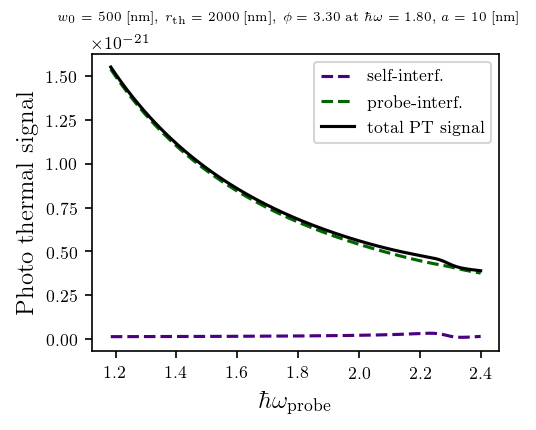

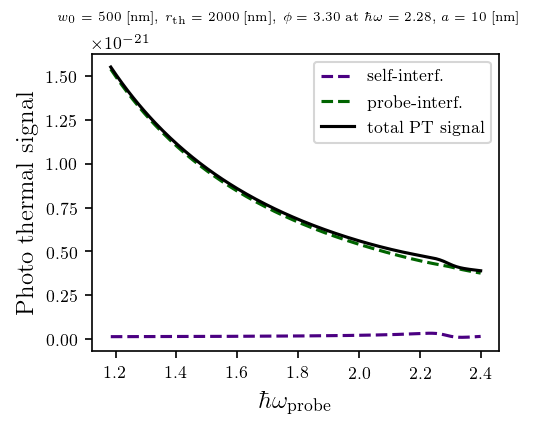

In [155]:
T_expansion = 0
r_th = 2000
w0 = 500
a = 10

hw = 1.8
plot_pti_term_comparison(T_expansion, r_th, w0, hw_for_phase=hw, a=a)

hw = 2.28
plot_pti_term_comparison(T_expansion, r_th, w0, hw_for_phase=hw, a=a)


Signal maximized at phase $\phi =  3.744524577006016
Signal maximized at phase $\phi =  3.744524577006016


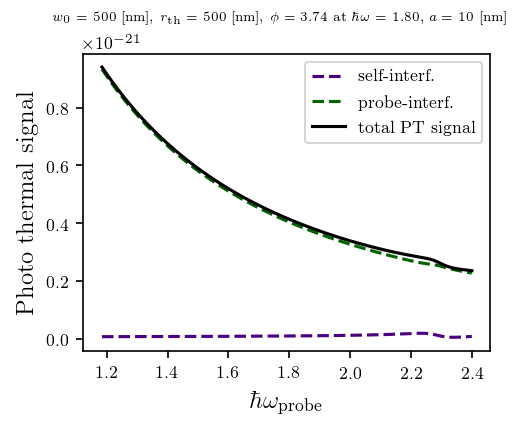

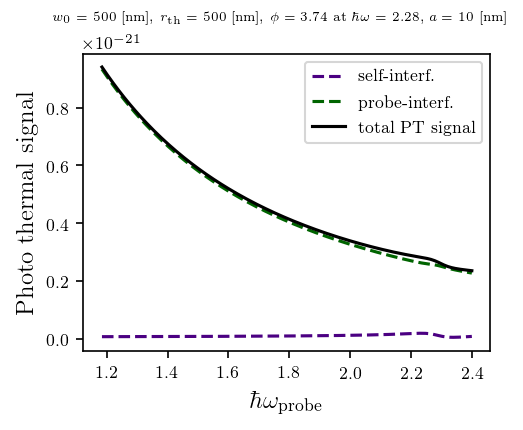

In [154]:
T_expansion = 0
r_th = 500
w0 = 500
a = 10

hw = 1.8
plot_pti_term_comparison(T_expansion, r_th, w0, hw_for_phase=hw, a=a)

hw = 2.28
plot_pti_term_comparison(T_expansion, r_th, w0, hw_for_phase=hw, a=a)


Signal maximized at phase $\phi =  3.8714576135146945
Signal maximized at phase $\phi =  3.8714576135146945


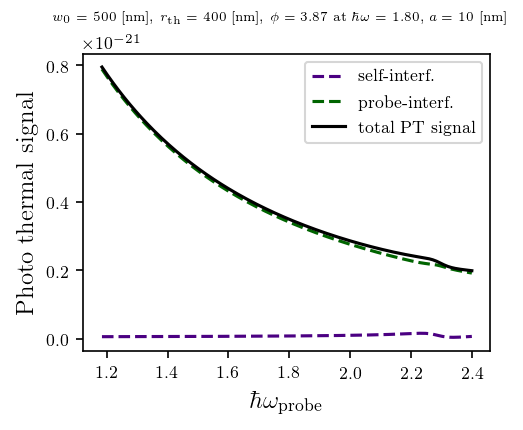

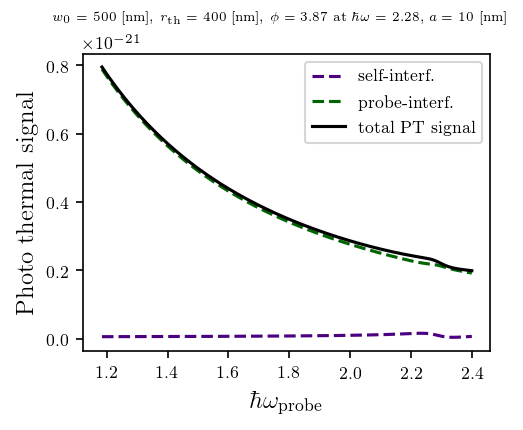

In [151]:
T_expansion = 0
r_th = 400
w0 = 500
a = 10

hw = 1.8
plot_pti_term_comparison(T_expansion, r_th, w0, hw_for_phase=hw, a=a)

hw = 2.28
plot_pti_term_comparison(T_expansion, r_th, w0, hw_for_phase=hw, a=a)


Signal maximized at phase $\phi =  4.759988869075444
Signal maximized at phase $\phi =  4.6330558325667655


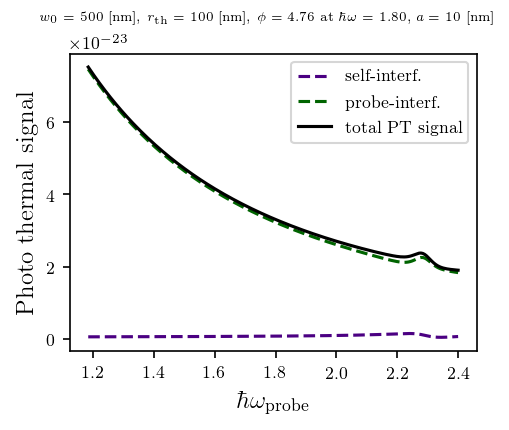

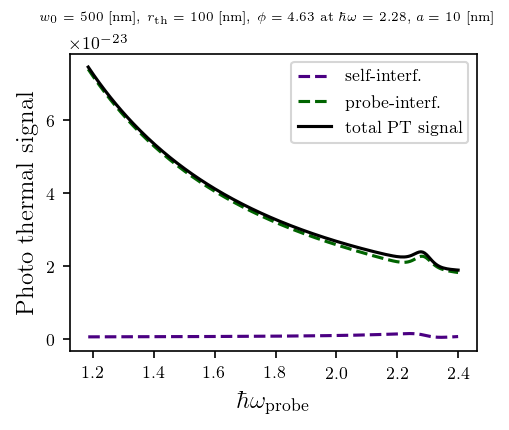

In [153]:
T_expansion = 0
r_th = 100
w0 = 500
a = 10

hw = 1.8
plot_pti_term_comparison(T_expansion, r_th, w0, hw_for_phase=hw, a=a)

hw = 2.28
plot_pti_term_comparison(T_expansion, r_th, w0, hw_for_phase=hw, a=a)


Signal maximized at phase $\phi =  4.696522350821105
Signal maximized at phase $\phi =  4.442656277803748


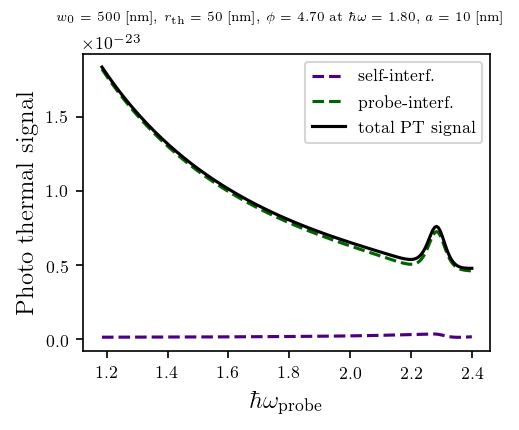

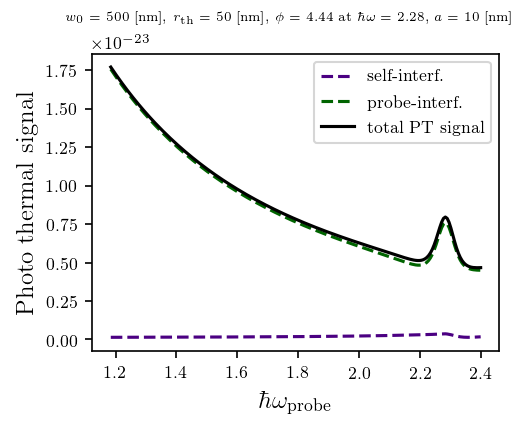

In [160]:
T_expansion = 0
r_th = 50
w0 = 500
a = 10

hw = 1.8
plot_pti_term_comparison(T_expansion, r_th, w0, hw_for_phase=hw, a=a)

hw = 2.28
plot_pti_term_comparison(T_expansion, r_th, w0, hw_for_phase=hw, a=a)


Signal maximized at phase $\phi =  4.759988869075444
Signal maximized at phase $\phi =  3.998390650023373


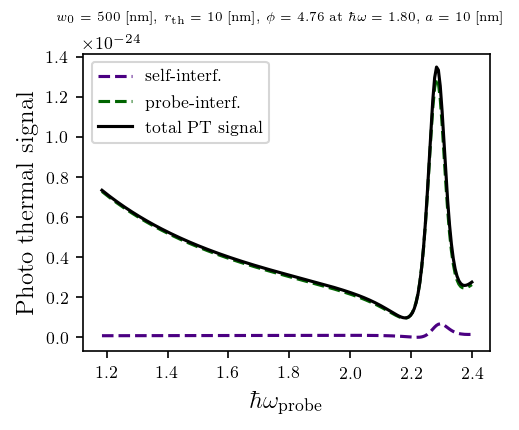

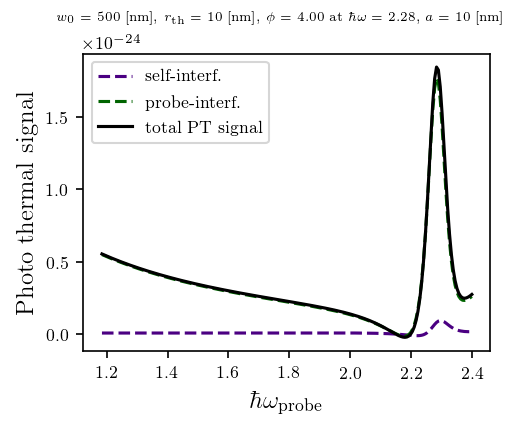

In [161]:
T_expansion = 0
r_th = 10
w0 = 500
a = 10

hw = 1.8
plot_pti_term_comparison(T_expansion, r_th, w0, hw_for_phase=hw, a=a)

hw = 2.28
plot_pti_term_comparison(T_expansion, r_th, w0, hw_for_phase=hw, a=a)


### Go to. bigger sphere

Signal maximized at phase $\phi =  3.3002589492256416
Signal maximized at phase $\phi =  3.3002589492256416


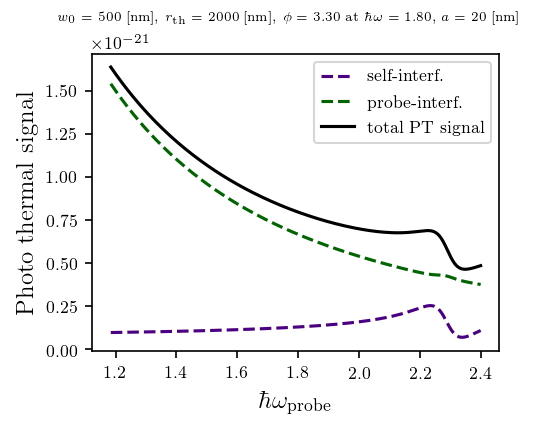

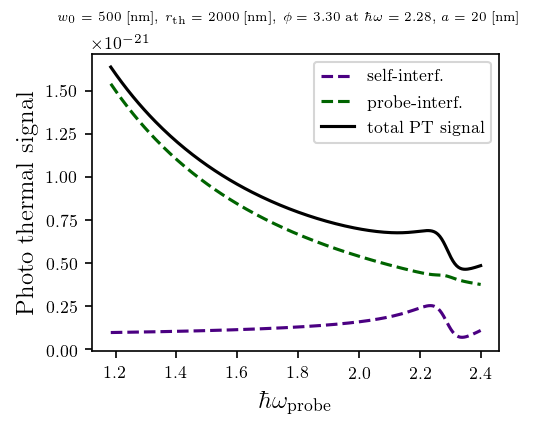

In [162]:
T_expansion = 0
r_th = 2000
w0 = 500
a = 20

hw = 1.8
plot_pti_term_comparison(T_expansion, r_th, w0, hw_for_phase=hw, a=a)

hw = 2.28
plot_pti_term_comparison(T_expansion, r_th, w0, hw_for_phase=hw, a=a)


Signal maximized at phase $\phi =  3.490658503988659
Signal maximized at phase $\phi =  3.490658503988659


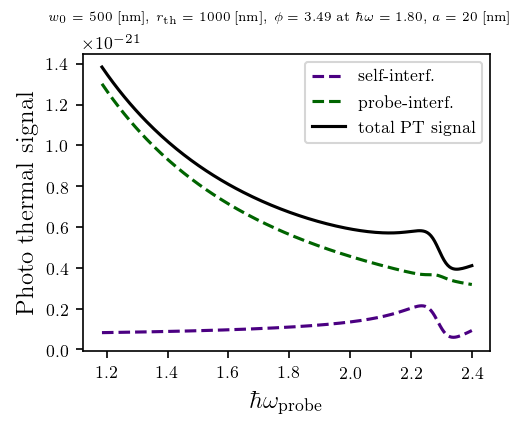

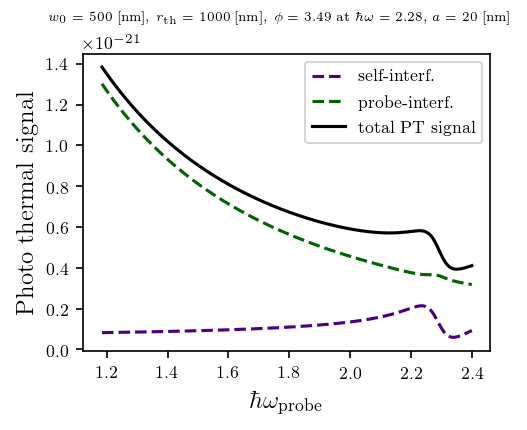

In [163]:
T_expansion = 0
r_th = 1000
w0 = 500
a = 20

hw = 1.8
plot_pti_term_comparison(T_expansion, r_th, w0, hw_for_phase=hw, a=a)

hw = 2.28
plot_pti_term_comparison(T_expansion, r_th, w0, hw_for_phase=hw, a=a)


Signal maximized at phase $\phi =  3.744524577006016
Signal maximized at phase $\phi =  3.744524577006016


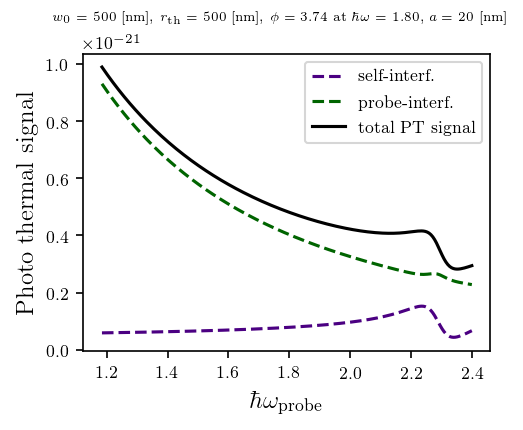

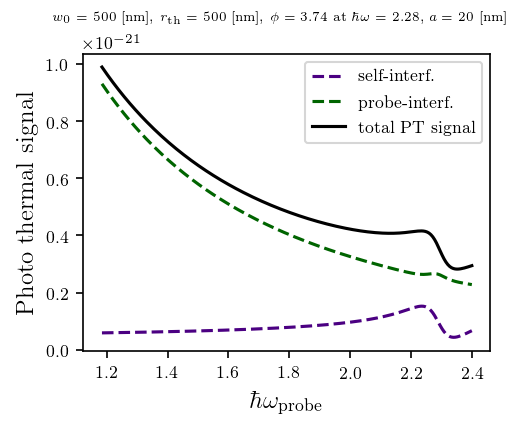

In [164]:
T_expansion = 0
r_th = 500
w0 = 500
a = 20

hw = 1.8
plot_pti_term_comparison(T_expansion, r_th, w0, hw_for_phase=hw, a=a)

hw = 2.28
plot_pti_term_comparison(T_expansion, r_th, w0, hw_for_phase=hw, a=a)


Signal maximized at phase $\phi =  4.25225672304073
Signal maximized at phase $\phi =  4.188790204786391


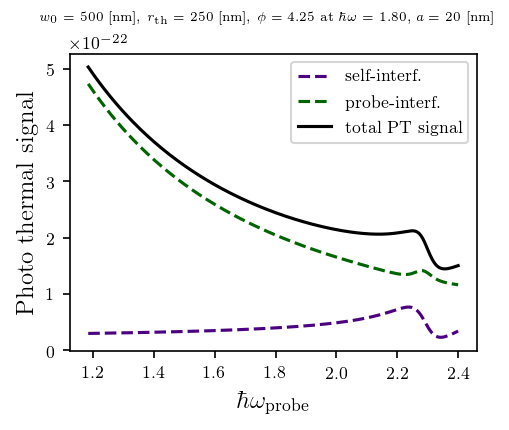

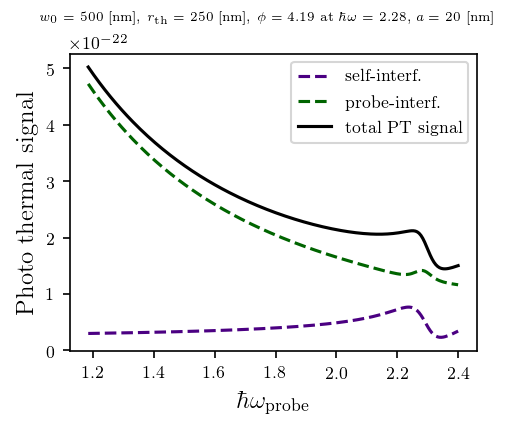

In [167]:
T_expansion = 0
r_th = 250
w0 = 500
a = 20

hw = 1.8
plot_pti_term_comparison(T_expansion, r_th, w0, hw_for_phase=hw, a=a)

hw = 2.28
plot_pti_term_comparison(T_expansion, r_th, w0, hw_for_phase=hw, a=a)


Signal maximized at phase $\phi =  4.759988869075444
Signal maximized at phase $\phi =  4.442656277803748


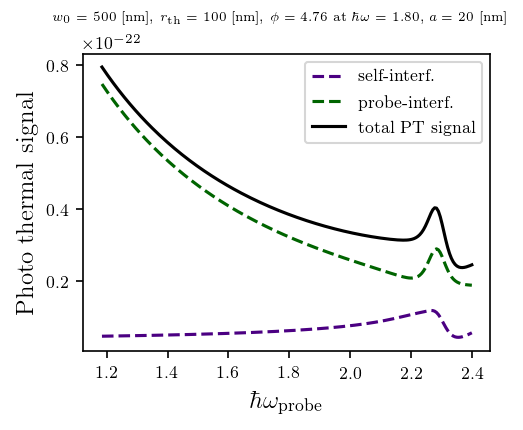

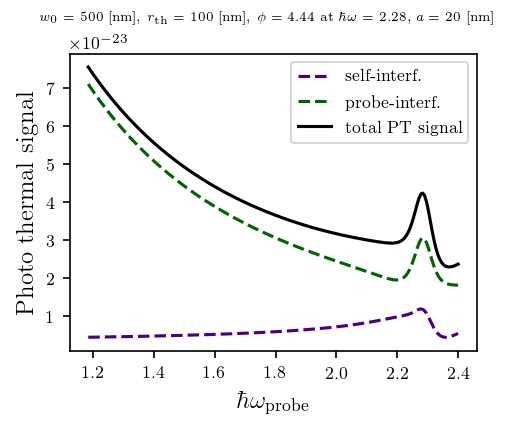

In [168]:
T_expansion = 0
r_th = 100
w0 = 500
a = 20

hw = 1.8
plot_pti_term_comparison(T_expansion, r_th, w0, hw_for_phase=hw, a=a)

hw = 2.28
plot_pti_term_comparison(T_expansion, r_th, w0, hw_for_phase=hw, a=a)


Signal maximized at phase $\phi =  4.696522350821105
Signal maximized at phase $\phi =  4.188790204786391


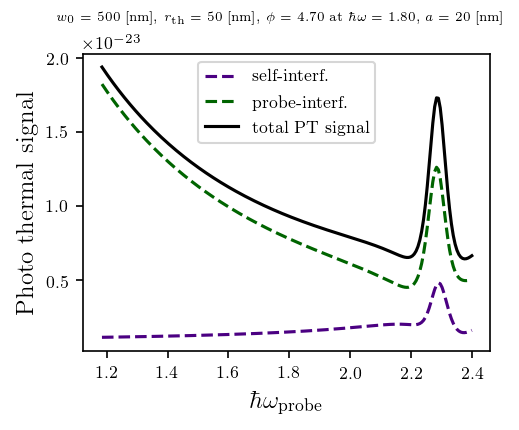

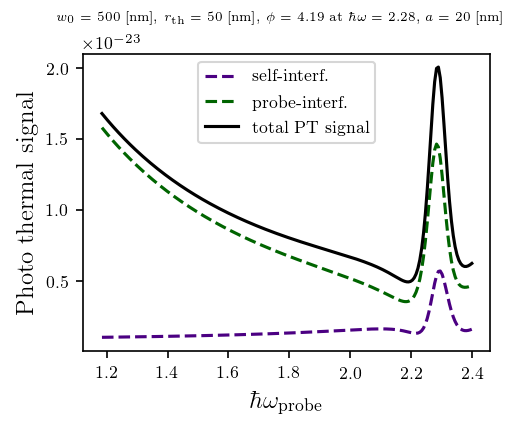

In [169]:
T_expansion = 0
r_th = 50
w0 = 500
a = 20

hw = 1.8
plot_pti_term_comparison(T_expansion, r_th, w0, hw_for_phase=hw, a=a)

hw = 2.28
plot_pti_term_comparison(T_expansion, r_th, w0, hw_for_phase=hw, a=a)


### and now a = 30nm 

Signal maximized at phase $\phi =  3.3002589492256416
Signal maximized at phase $\phi =  3.3637254674799806


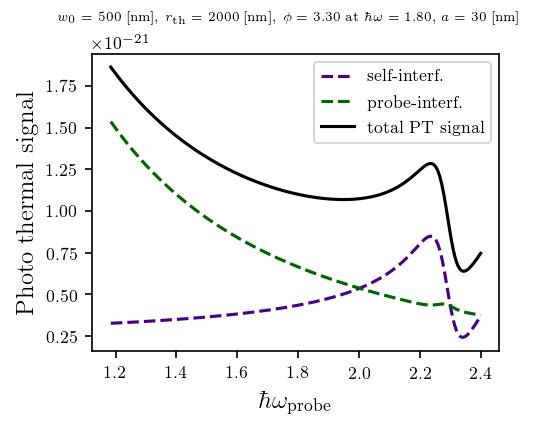

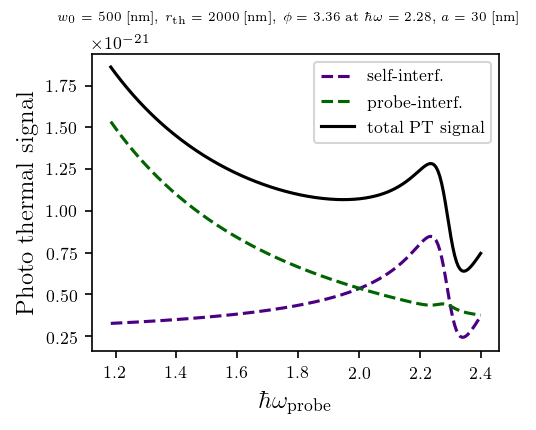

In [170]:
T_expansion = 0
r_th = 2000
w0 = 500
a = 30

hw = 1.8
plot_pti_term_comparison(T_expansion, r_th, w0, hw_for_phase=hw, a=a)

hw = 2.28
plot_pti_term_comparison(T_expansion, r_th, w0, hw_for_phase=hw, a=a)


Signal maximized at phase $\phi =  3.490658503988659
Signal maximized at phase $\phi =  3.490658503988659


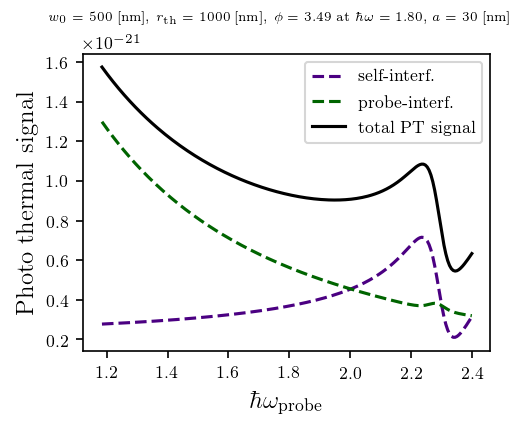

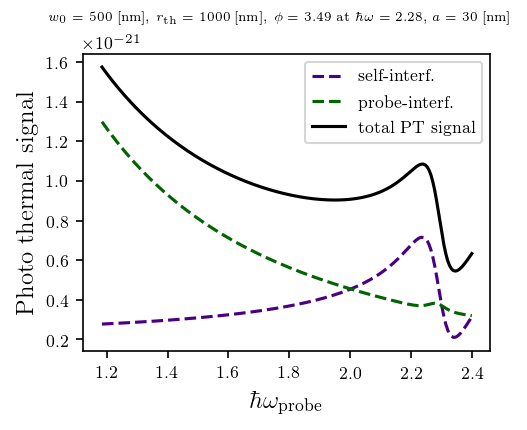

In [171]:
T_expansion = 0
r_th = 1000
w0 = 500
a = 30

hw = 1.8
plot_pti_term_comparison(T_expansion, r_th, w0, hw_for_phase=hw, a=a)

hw = 2.28
plot_pti_term_comparison(T_expansion, r_th, w0, hw_for_phase=hw, a=a)


Signal maximized at phase $\phi =  3.744524577006016
Signal maximized at phase $\phi =  3.744524577006016


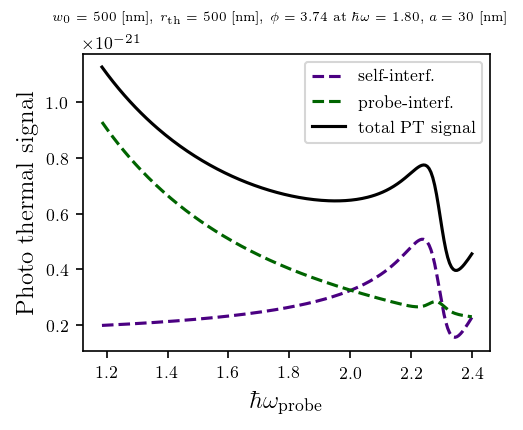

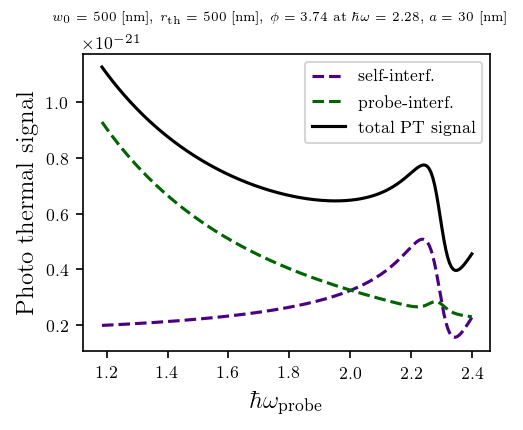

In [172]:
T_expansion = 0
r_th = 500
w0 = 500
a = 30

hw = 1.8
plot_pti_term_comparison(T_expansion, r_th, w0, hw_for_phase=hw, a=a)

hw = 2.28
plot_pti_term_comparison(T_expansion, r_th, w0, hw_for_phase=hw, a=a)


Signal maximized at phase $\phi =  4.25225672304073
Signal maximized at phase $\phi =  4.188790204786391


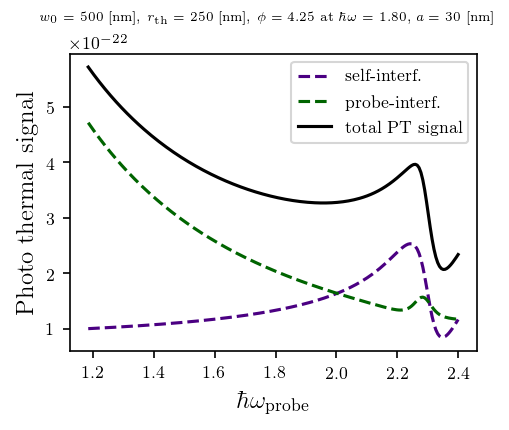

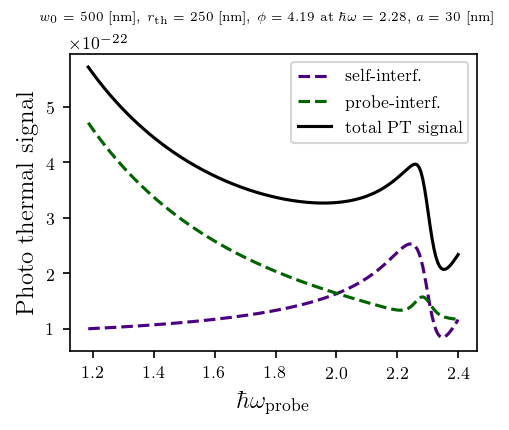

In [173]:
T_expansion = 0
r_th = 250
w0 = 500
a = 30

hw = 1.8
plot_pti_term_comparison(T_expansion, r_th, w0, hw_for_phase=hw, a=a)

hw = 2.28
plot_pti_term_comparison(T_expansion, r_th, w0, hw_for_phase=hw, a=a)


Signal maximized at phase $\phi =  4.759988869075444
Signal maximized at phase $\phi =  4.3157232412950695


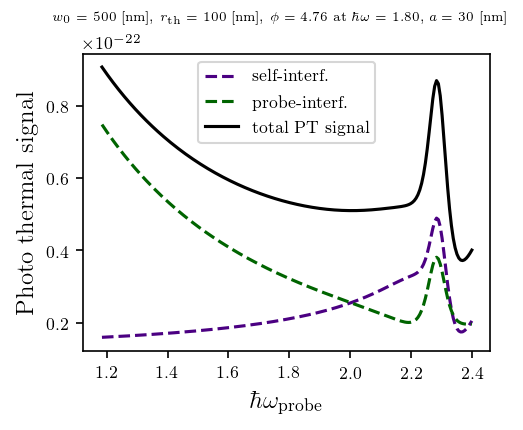

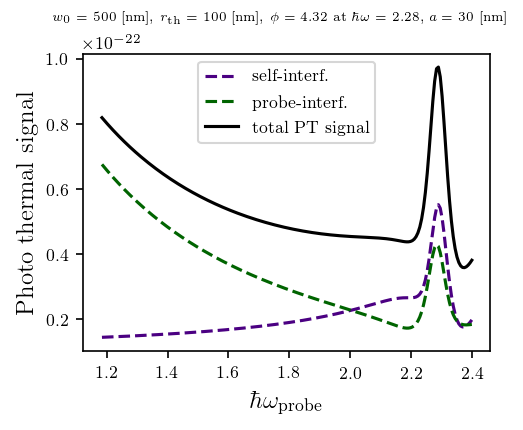

In [174]:
T_expansion = 0
r_th = 100
w0 = 500
a = 30

hw = 1.8
plot_pti_term_comparison(T_expansion, r_th, w0, hw_for_phase=hw, a=a)

hw = 2.28
plot_pti_term_comparison(T_expansion, r_th, w0, hw_for_phase=hw, a=a)


Signal maximized at phase $\phi =  4.759988869075444
Signal maximized at phase $\phi =  4.1253236865320515


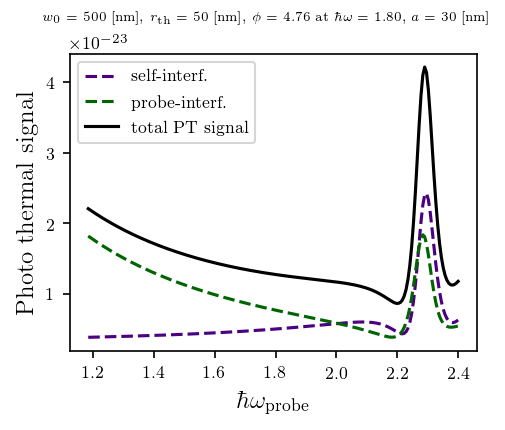

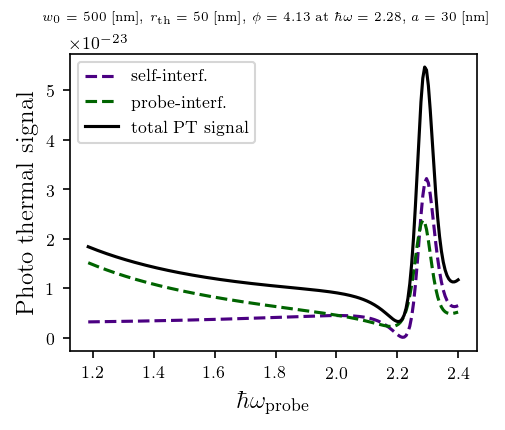

In [175]:
T_expansion = 0
r_th = 50
w0 = 500
a = 30

hw = 1.8
plot_pti_term_comparison(T_expansion, r_th, w0, hw_for_phase=hw, a=a)

hw = 2.28
plot_pti_term_comparison(T_expansion, r_th, w0, hw_for_phase=hw, a=a)


### a = 40 nm

Signal maximized at phase $\phi =  3.3002589492256416
Signal maximized at phase $\phi =  3.3637254674799806


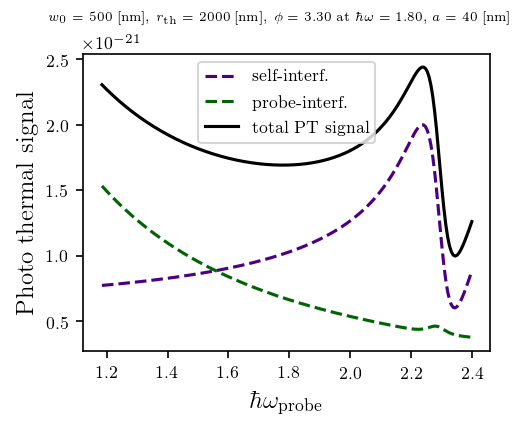

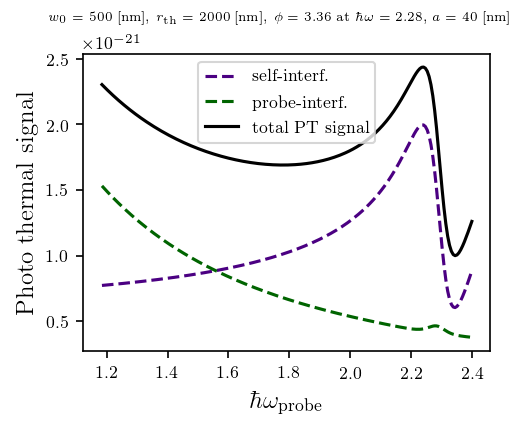

In [176]:
T_expansion = 0
r_th = 2000
w0 = 500
a = 40

hw = 1.8
plot_pti_term_comparison(T_expansion, r_th, w0, hw_for_phase=hw, a=a)

hw = 2.28
plot_pti_term_comparison(T_expansion, r_th, w0, hw_for_phase=hw, a=a)


Signal maximized at phase $\phi =  3.490658503988659
Signal maximized at phase $\phi =  3.490658503988659


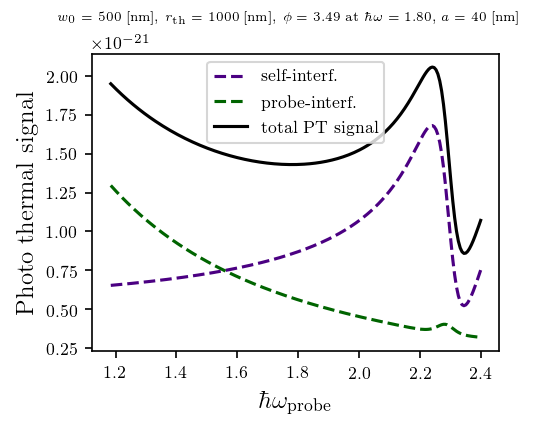

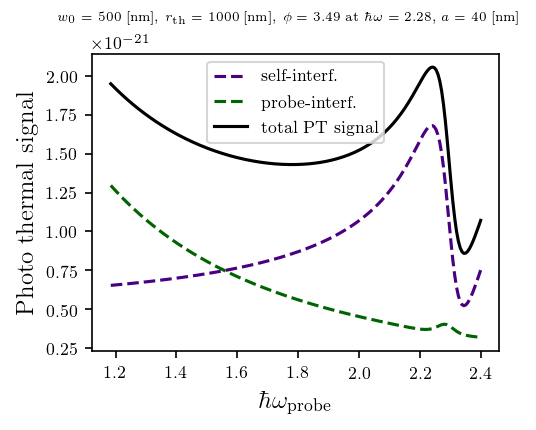

In [177]:
T_expansion = 0
r_th = 1000
w0 = 500
a = 40

hw = 1.8
plot_pti_term_comparison(T_expansion, r_th, w0, hw_for_phase=hw, a=a)

hw = 2.28
plot_pti_term_comparison(T_expansion, r_th, w0, hw_for_phase=hw, a=a)


Signal maximized at phase $\phi =  3.744524577006016
Signal maximized at phase $\phi =  3.8079910952603555


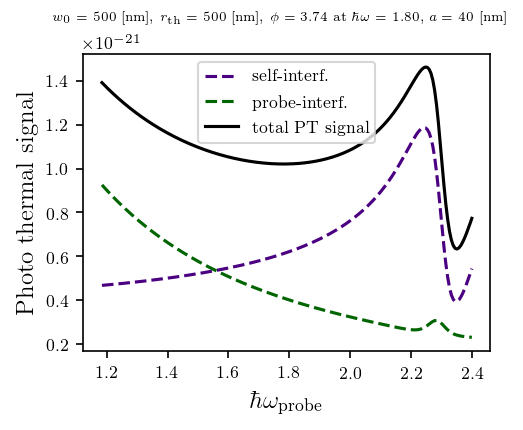

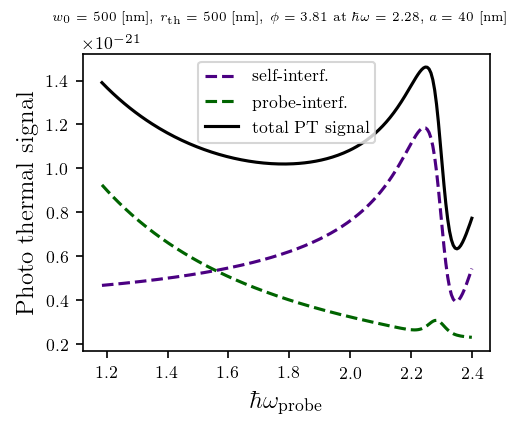

In [178]:
T_expansion = 0
r_th = 500
w0 = 500
a = 40

hw = 1.8
plot_pti_term_comparison(T_expansion, r_th, w0, hw_for_phase=hw, a=a)

hw = 2.28
plot_pti_term_comparison(T_expansion, r_th, w0, hw_for_phase=hw, a=a)


Signal maximized at phase $\phi =  4.25225672304073
Signal maximized at phase $\phi =  4.1253236865320515


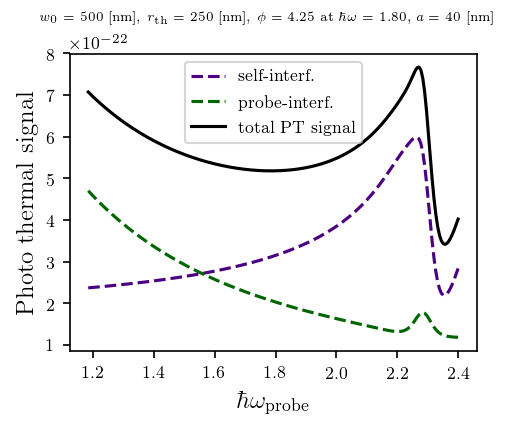

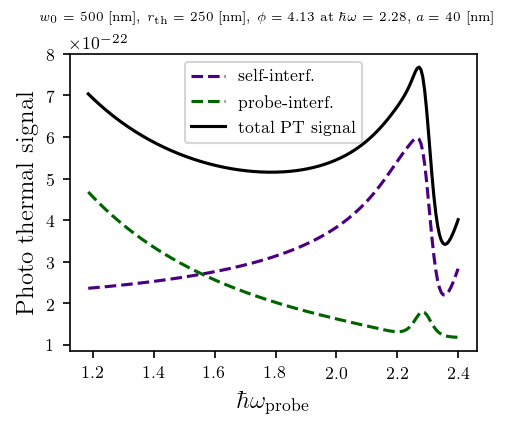

In [179]:
T_expansion = 0
r_th = 250
w0 = 500
a = 40

hw = 1.8
plot_pti_term_comparison(T_expansion, r_th, w0, hw_for_phase=hw, a=a)

hw = 2.28
plot_pti_term_comparison(T_expansion, r_th, w0, hw_for_phase=hw, a=a)


Signal maximized at phase $\phi =  4.759988869075444
Signal maximized at phase $\phi =  4.25225672304073


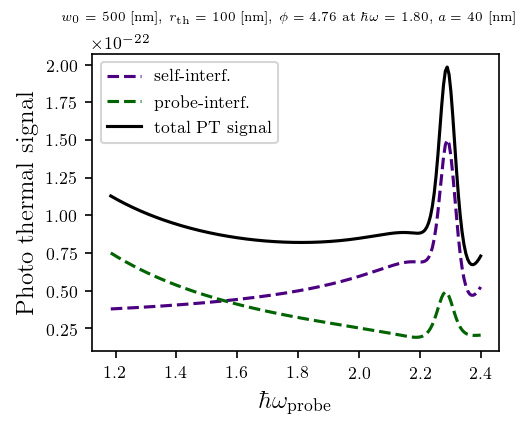

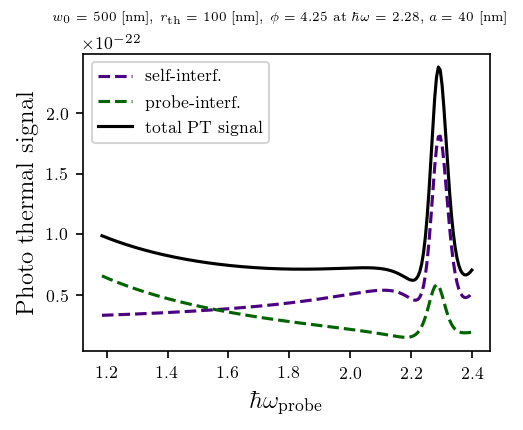

In [180]:
T_expansion = 0
r_th = 100
w0 = 500
a = 40

hw = 1.8
plot_pti_term_comparison(T_expansion, r_th, w0, hw_for_phase=hw, a=a)

hw = 2.28
plot_pti_term_comparison(T_expansion, r_th, w0, hw_for_phase=hw, a=a)
